In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def train_val_generators(training_dir, validation_dir):

    train_datagen = ImageDataGenerator(rescale=1./255.)

    train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                        batch_size=16,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

    validation_datagen = ImageDataGenerator(rescale=1./255.)

    validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                  batch_size=16,
                                                                  class_mode='categorical',
                                                                  target_size=(150, 150))

    return train_generator, validation_generator

In [3]:
training_dir = '/Acne/Train'
validation_dir = '/Acne/Validation'
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 10789 images belonging to 3 classes.
Found 5176 images belonging to 3 classes.


In [4]:
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in mobilenet.layers:
    layer.trainable = False

model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

17225924/17225924 [==============================] - 0s 0us/step


In [5]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/15
675/675 [==============================] - 67s 89ms/step - loss: 0.0842 - accuracy: 0.9659 - val_loss: 0.0191 - val_accuracy: 0.9921
Epoch 2/15
675/675 [==============================] - 29s 42ms/step - loss: 0.0446 - accuracy: 0.9817 - val_loss: 0.0175 - val_accuracy: 0.9927
Epoch 3/15
675/675 [==============================] - 28s 41ms/step - loss: 0.0299 - accuracy: 0.9866 - val_loss: 0.0167 - val_accuracy: 0.9929
Epoch 4/15
675/675 [==============================] - 29s 43ms/step - loss: 0.0219 - accuracy: 0.9922 - val_loss: 0.0193 - val_accuracy: 0.9927
Epoch 5/15
675/675 [==============================] - 28s 41ms/step - loss: 0.0171 - accuracy: 0.9930 - val_loss: 0.0221 - val_accuracy: 0.9927
Epoch 6/15
675/675 [==============================] - 30s 44ms/step - loss: 0.0120 - accuracy: 0.9954 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 7/15
675/675 [==============================] - 28s 42ms/step - loss: 0.0105 - accuracy: 0.9962 - val_loss: 0.0322 - val_accuracy:

In [7]:
true_classes = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())

predicted_classes = model.predict(validation_generator)
predicted_classes = np.argmax(predicted_classes, axis=1)

precision, recall, f1_score, support = precision_recall_fscore_support(
    true_classes, predicted_classes, average='weighted', labels=np.unique(predicted_classes))

accuracy = accuracy_score(true_classes, predicted_classes)

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1_score)
print('Accuracy:', accuracy)

324/324 [==============================] - 9s 26ms/step
Precision: 0.8550626322844253
Recall: 0.8551004636785162
F1-Score: 0.8550653323015291
Accuracy: 0.8551004636785162


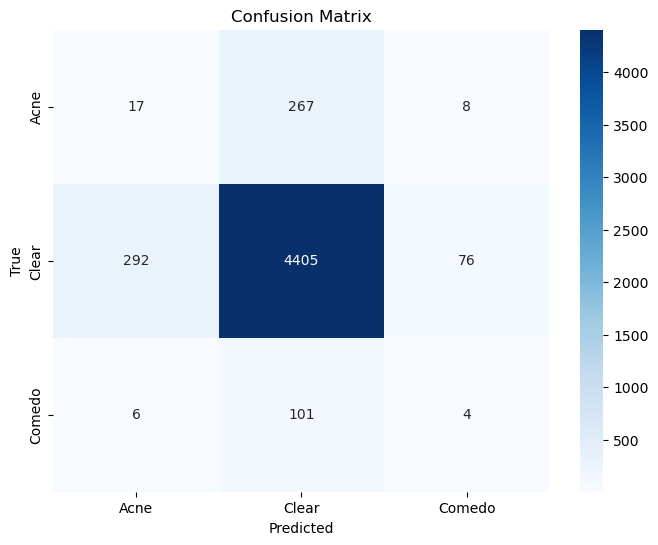

In [8]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

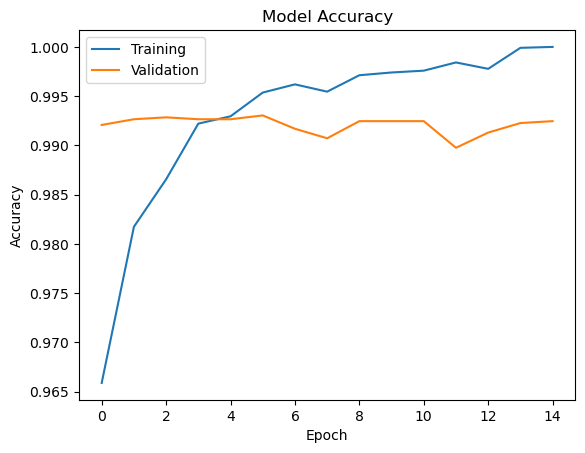

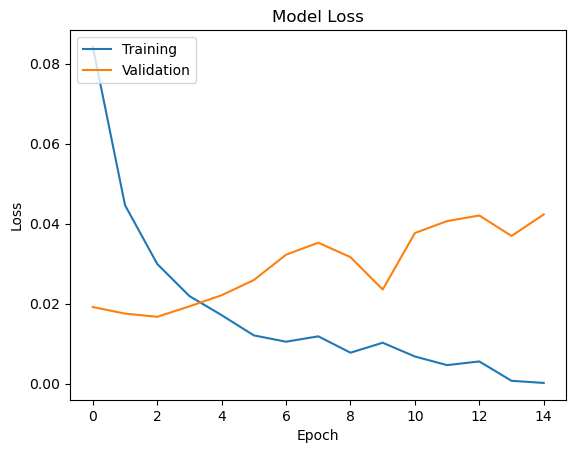

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [10]:
model.save('/kaggle/working/acne_model.h5')

In [11]:
from IPython.display import FileLink
%cd /kaggle/working

FileLink(r'acne_model.h5')

/kaggle/working


/kaggle/working/acne_model.h5